# Assignment: Linear Models, Regularization, and Model Selection on Real Data

Integrantes:

- Calle Chambe, Efraín

- Poma Huamán, Brayan

- Sánchez Vásquez, Barbara Gabriela

## Part A. Linear Regression From Scratch

### 1. **Dataset**
   Use the **California Housing dataset** (`from sklearn.datasets import fetch_california_housing`).

In [31]:
# Import basic packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.datasets import fetch_california_housing

   * Predict the median house value (`MedHouseVal`) from the remaining features.

In [4]:
# California Housing dataset

rd = fetch_california_housing(as_frame=True)

X = rd.data
y = rd.target # MedianHouseValue

print(X.shape)
print(y.shape)
print("Features:", X.columns.tolist())
print("Target:", y.name)

(20640, 8)
(20640,)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: MedHouseVal


   * Create a hold-out test set.


In [5]:
# Hold-out set

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=20)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(16512, 8)
(4128, 8)
(16512,)
(4128,)


   * Standardize features to zero mean and unit variance

In [6]:
# Standardize features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Mean: ", X_train_scaled.mean(axis=0))
print("Variance: ", X_train_scaled.std(axis=0))


Mean:  [-8.72471776e-17  8.28901977e-17 -2.51467667e-17 -6.70490795e-17
  6.96040985e-17 -3.99120874e-17 -4.53585812e-15 -2.75108317e-15]
Variance:  [1. 1. 1. 1. 1. 1. 1. 1.]



### 2. **Closed-form OLS**


   

   * Derive and implement $\hat\beta = (X^\top X)^{-1}X^\top y$ using only `numpy`.

**Derivating from RSS to Normal Equation**

We know:

$$
\mathrm{RSS}(\beta) = \|Y - X\beta\|_2^2 = (Y - X\beta)^\top (Y - X\beta)
$$
Also:

$$
\mathrm{RSS}(\beta) = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Where we define the predicted value as
$$
\hat{y}_i = x_i^\top \beta
$$

So:

$$\mathrm{RSS}(\beta) = \sum_{i=1}^{n} (y_i - x_i^\top \beta)^2$$

Deriving:

$$
\frac{\partial\, \mathrm{RSS}(\beta)}{\partial \beta} = -2 \sum_{i=1}^{n} x_i^\top (y_i - x_i^\top \beta)
$$

Matrix form:
$$
\frac{\partial\, \mathrm{RSS}(\beta)}{\partial \beta} = -2 X^\top (Y - X\beta)
$$

F.O.C.

Then, we do $\frac{\partial\, \mathrm{RSS}(\beta)}{\partial \beta} = 0$ to obtain the $\hat{\beta}$ that minimize this loss:

$$
-2 X^\top (Y - X\beta) = 0
$$
$$
X^\top Y - X^\top X \beta = 0
$$

$$
X^\top Y = X^\top X \beta
$$

Then, assuming  $(X^\top X)$ can be inverted, we finally get:

$$
\hat{\beta} = (X^\top X)^{-1} X^\top Y
$$

In [7]:
# Closed-form OLS

X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled] # adding intercept term

beta_hat = np.linalg.inv(X_train_b.T.dot(X_train_b)).dot(X_train_b.T).dot(y_train)

X_train_b.shape

(16512, 9)

   * Report coefficients and intercept.

In [8]:
# Report coefficients and intercept

print("Coefficients:", beta_hat[1:])
print("Intercept:", beta_hat[0])

Coefficients: [ 0.83275185  0.1173856  -0.27597663  0.29900186 -0.00795271 -0.03963673
 -0.88241635 -0.85338011]
Intercept: 2.0678235537790446


   * Plot predicted vs. true median house value on a held-out test set.

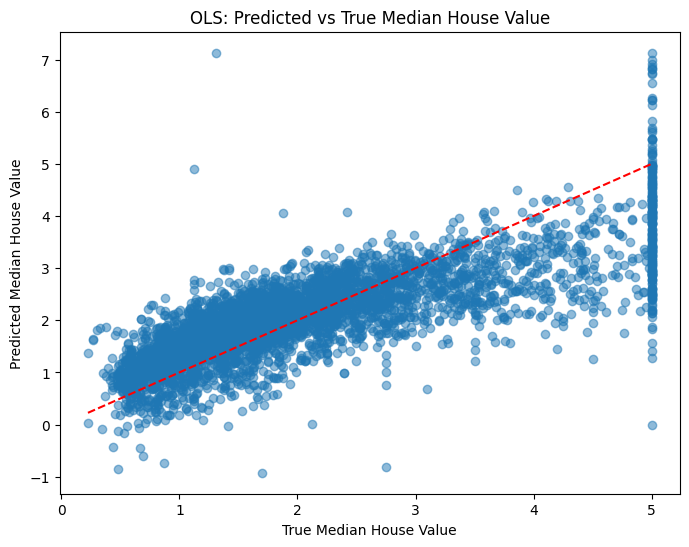

In [9]:
# Plot predicted vs true on test set

X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled] # adding intercept term
y_pred = X_test_b.dot(beta_hat)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("OLS: Predicted vs True Median House Value")
plt.show()

3. **Gradient Descent**


   * Implement gradient descent to minimize mean squared error.


In [10]:

def mean_squared_error(theta, X, y):
    """The cost function, J, describing the goodness of fit.

    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets
    """
    return 0.5*np.mean((y-X.dot(theta))**2)

def mse_gradient(theta, X, y):
    """The gradient of the cost function.

    Parameters:
    theta (np.array): d-dimensional vector of parameters
    X (np.array): (n,d)-dimensional design matrix
    y (np.array): n-dimensional vector of targets

    Returns:
    grad (np.array): d-dimensional gradient of the MSE
    """
    grad = np.dot(X.T, (np.dot(X, theta) - y)) / X.shape[0] # fixed
    return grad

   * Experiment with at least two learning rates; show cost vs. iteration curves.

In [11]:
print("=== EXPERIMENT 1: Learning Rate = 0.1 ===")

threshold = 1e-3
step_size = 0.1
max_iter = 10000
theta, theta_prev = np.array([2,1] + [0]*(X_train_b.shape[1]-2)), np.ones(X_train_b.shape[1])
cost_history1 = []
iter = 0

while np.linalg.norm(theta - theta_prev) > threshold and iter < max_iter:
    if iter % 100 == 0:
        current_mse = mean_squared_error(theta, X_train_b, y_train)
        print('Iteration %d. MSE: %.6f' % (iter, current_mse))
    
    # Saving the cost for plotting
    cost_history1.append(mean_squared_error(theta, X_train_b, y_train))
    
    theta_prev = theta.copy()
    gradient = mse_gradient(theta, X_train_b, y_train)
    theta = theta_prev - step_size * gradient
    iter += 1

# Adding last cost
final_cost1 = mean_squared_error(theta, X_train_b, y_train)
cost_history1.append(final_cost1)
print('Final iteration %d. MSE: %.6f' % (iter, final_cost1))

# Saving results
theta_gd1 = theta.copy()
iterations1 = iter

print("Converged in %d iterations" % iterations1)
print("Intercept:", theta_gd1[0])
print("Coefficients:", theta_gd1[1:])
print()



=== EXPERIMENT 1: Learning Rate = 0.1 ===
Iteration 0. MSE: 0.374608
Iteration 100. MSE: 0.273664
Iteration 200. MSE: 0.263972
Iteration 300. MSE: 0.261522
Final iteration 319. MSE: 0.261313
Converged in 319 iterations
Intercept: 2.067823553779063
Coefficients: [ 0.86527893  0.13094156 -0.32138585  0.32917001 -0.00336916 -0.04170878
 -0.75249279 -0.72664036]



In [12]:
print("=== EXPERIMENT 2: Learning Rate = 0.5 ===")

threshold = 1e-3
step_size = 0.5
max_iter = 10000
theta, theta_prev = np.array([2,1] + [0]*(X_train_b.shape[1]-2)), np.ones(X_train_b.shape[1])
cost_history2 = []
iter = 0

while np.linalg.norm(theta - theta_prev) > threshold and iter < max_iter:
    if iter % 100 == 0:
        current_mse = mean_squared_error(theta, X_train_b, y_train)
        print('Iteration %d. MSE: %.6f' % (iter, current_mse))
        
    # Saving the cost for plotting
    cost_history2.append(mean_squared_error(theta, X_train_b, y_train))
    
    theta_prev = theta.copy()
    gradient = mse_gradient(theta, X_train_b, y_train)
    theta = theta_prev - step_size * gradient
    iter += 1

# Adding last cost
final_cost2 = mean_squared_error(theta, X_train_b, y_train)
cost_history2.append(final_cost2)
print('Final iteration %d. MSE: %.6f' % (iter, final_cost2))

# Saving results
theta_gd2 = theta.copy()
iterations2 = iter

print("Converged in %d iterations" % iterations2)
print("Intercept:", theta_gd2[0])
print("Coefficients:", theta_gd2[1:])
print()

=== EXPERIMENT 2: Learning Rate = 0.5 ===
Iteration 0. MSE: 0.374608
Iteration 100. MSE: 0.260537
Final iteration 127. MSE: 0.260432
Converged in 127 iterations
Intercept: 2.0678235537790637
Coefficients: [ 0.84256619  0.11958016 -0.29292033  0.31227628 -0.00731143 -0.04008688
 -0.85665873 -0.82874495]



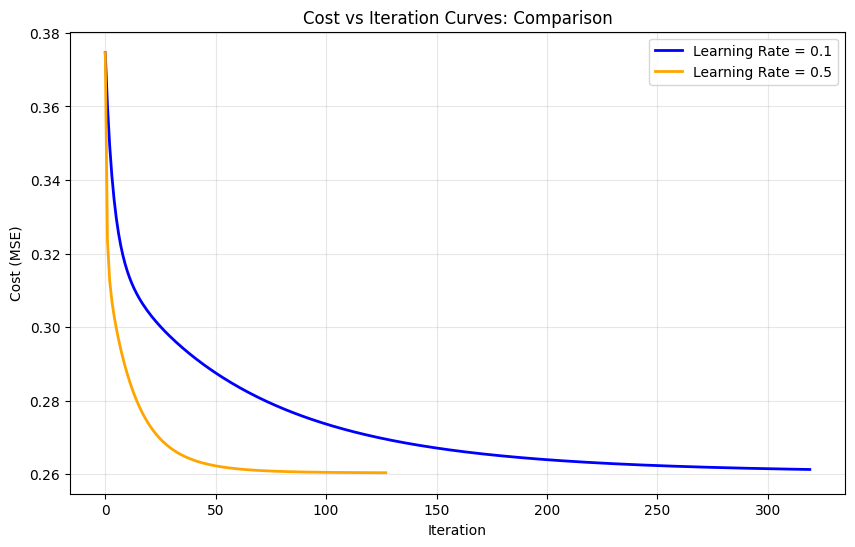

In [13]:
# Showing cost vs. iteration curves
plt.figure(figsize=(10, 6))
plt.plot(cost_history1, label='Learning Rate = 0.1', linewidth=2, color='blue')
plt.plot(cost_history2, label='Learning Rate = 0.5', linewidth=2, color='orange')
plt.xlabel('Iteration')
plt.ylabel('Cost (MSE)')
plt.title('Cost vs Iteration Curves: Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


=== GRADIENT DESCENT CONTOUR PLOT ===


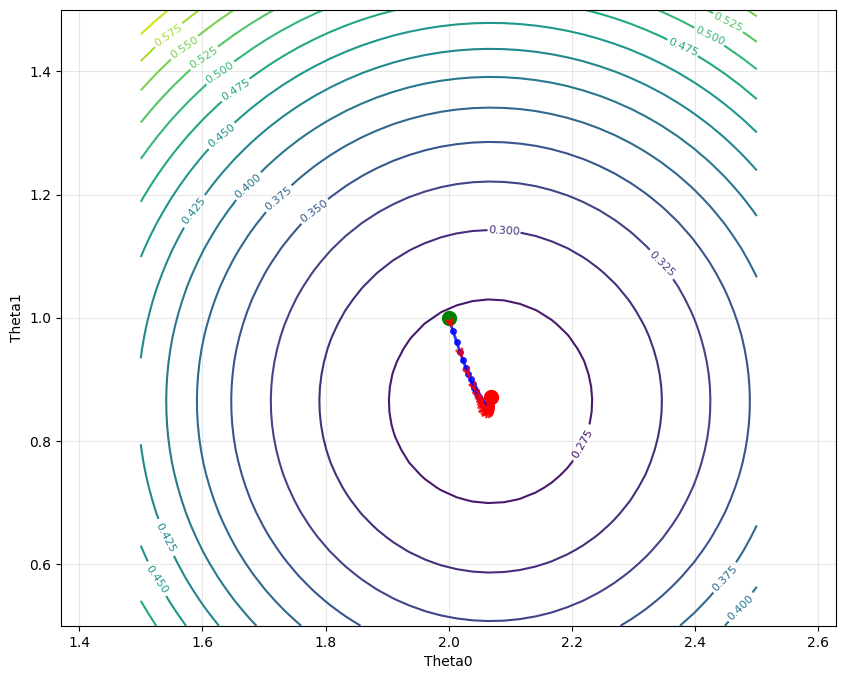

In [14]:
# Contour Plot Visualization

print("\n=== GRADIENT DESCENT CONTOUR PLOT ===") # Only for 2 features


def mse_2d(theta0, theta1, fixed_theta):
    theta_full = fixed_theta.copy()
    theta_full[0] = theta0
    theta_full[1] = theta1
    return mean_squared_error(theta_full, X_train_b, y_train)

# Creating grid for contour plot
theta0_range = np.linspace(1.5, 2.5, 40)
theta1_range = np.linspace(0.5, 1.5, 50)
theta0_grid, theta1_grid = np.meshgrid(theta0_range, theta1_range)

base_theta = theta_gd1.copy()

# Evaluating MSE on the grid
mse_grid = np.zeros_like(theta0_grid)
for i in range(len(theta0_range)):
    for j in range(len(theta1_range)):
        mse_grid[j, i] = mse_2d(theta0_grid[j, i], theta1_grid[j, i], base_theta)


theta, theta_prev = np.array([2,1] + [0]*(X_train_b.shape[1]-2)), np.ones(X_train_b.shape[1])
step_size = 0.1
trajectory_theta0 = [theta[0]]
trajectory_theta1 = [theta[1]]
trajectory_gradients = []
iter = 0

while np.linalg.norm(theta - theta_prev) > threshold and iter < max_iter:
    theta_prev = theta.copy()
    gradient = mse_gradient(theta, X_train_b, y_train)
    theta = theta_prev - step_size * gradient
    
    trajectory_theta0.append(theta[0])
    trajectory_theta1.append(theta[1])
    trajectory_gradients.append(gradient[:2])
    
    iter += 1
    if iter > 100:
        break

# Contour plot
plt.figure(figsize=(10, 8))

# Level curves
contours = plt.contour(theta0_grid, theta1_grid, mse_grid, levels=15)
plt.clabel(contours, inline=True, fontsize=8)

# Trajectory of gradient descent
trajectory_theta0 = np.array(trajectory_theta0)
trajectory_theta1 = np.array(trajectory_theta1)
plt.plot(trajectory_theta0, trajectory_theta1, 'bo-', markersize=4, linewidth=2, alpha=0.8, label='GD Path')

# Start and end points
plt.plot(trajectory_theta0[0], trajectory_theta1[0], 'go', markersize=10, label='Start')
plt.plot(trajectory_theta0[-1], trajectory_theta1[-1], 'ro', markersize=10, label='End')

# Arrows for gradients
for i in range(0, len(trajectory_theta0)-1, 3):
    if i < len(trajectory_gradients):
        grad = trajectory_gradients[i]

        plt.annotate('', xy=(trajectory_theta0[i] - 0.1*grad[0], trajectory_theta1[i] - 0.1*grad[1]),
                    xytext=(trajectory_theta0[i], trajectory_theta1[i]),
                    arrowprops={'arrowstyle': '->', 'lw': 2, 'color': 'red', 'alpha': 0.8})

plt.xlabel('Theta0')
plt.ylabel('Theta1')

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()


   * Compare parameters and test error to the closed-form OLS.

In [15]:
# COMPARE PARAMETERS WITH CLOSED-FORM OLS

print("=== COMPARISON WITH CLOSED-FORM OLS ===")

print("Parameters comparison:")
print("Closed-form OLS:")
print("  Intercept: %.6f" % beta_hat[0])
print("  Coefficients: [", end="")
for i, coef in enumerate(beta_hat[1:]):
    print("%.6f" % coef, end="")
    if i < len(beta_hat[1:]) - 1:
        print(", ", end="")
print("]")

print("\nGradient Descent (Learning Rate = 0.1):")
print("  Intercept: %.6f" % theta_gd1[0])
print("  Coefficients: [", end="")
for i, coef in enumerate(theta_gd1[1:]):
    print("%.6f" % coef, end="")
    if i < len(theta_gd1[1:]) - 1:
        print(", ", end="")
print("]")

print("\nGradient Descent (Learning Rate = 0.5):")
print("  Intercept: %.6f" % theta_gd2[0])
print("  Coefficients: [", end="")
for i, coef in enumerate(theta_gd2[1:]):
    print("%.6f" % coef, end="")
    if i < len(theta_gd2[1:]) - 1:
        print(", ", end="")
print("]")

# Parameter differences
diff1 = np.linalg.norm(theta_gd1 - beta_hat)
diff2 = np.linalg.norm(theta_gd2 - beta_hat)
print("\nParameter differences (L2 norm):")
print("  |θ_GD1 - θ_OLS|: %.8f" % diff1)
print("  |θ_GD2 - θ_OLS|: %.8f" % diff2)

# Test error comparison
test_mse_ols = mean_squared_error(beta_hat, X_test_b, y_test)
test_mse_gd1 = mean_squared_error(theta_gd1, X_test_b, y_test)
test_mse_gd2 = mean_squared_error(theta_gd2, X_test_b, y_test)

print("\nTest Error (MSE):")
print("  Closed-form OLS: %.6f" % test_mse_ols)
print("  Gradient Descent (lr=0.1): %.6f" % test_mse_gd1)
print("  Gradient Descent (lr=0.5): %.6f" % test_mse_gd2)

print("\nTest Error differences:")
print("  |MSE_GD1 - MSE_OLS|: %.8f" % abs(test_mse_gd1 - test_mse_ols))
print("  |MSE_GD2 - MSE_OLS|: %.8f" % abs(test_mse_gd2 - test_mse_ols))

=== COMPARISON WITH CLOSED-FORM OLS ===
Parameters comparison:
Closed-form OLS:
  Intercept: 2.067824
  Coefficients: [0.832752, 0.117386, -0.275977, 0.299002, -0.007953, -0.039637, -0.882416, -0.853380]

Gradient Descent (Learning Rate = 0.1):
  Intercept: 2.067824
  Coefficients: [0.865279, 0.130942, -0.321386, 0.329170, -0.003369, -0.041709, -0.752493, -0.726640]

Gradient Descent (Learning Rate = 0.5):
  Intercept: 2.067824
  Coefficients: [0.842566, 0.119580, -0.292920, 0.312276, -0.007311, -0.040087, -0.856659, -0.828745]

Parameter differences (L2 norm):
  |θ_GD1 - θ_OLS|: 0.19282710
  |θ_GD2 - θ_OLS|: 0.04284153

Test Error (MSE):
  Closed-form OLS: 0.270503
  Gradient Descent (lr=0.1): 0.272973
  Gradient Descent (lr=0.5): 0.270921

Test Error differences:
  |MSE_GD1 - MSE_OLS|: 0.00247018
  |MSE_GD2 - MSE_OLS|: 0.00041803



## Part B. Scikit-learn Linear Models

4. **Baseline**

   * Use `LinearRegression` and confirm the coefficients match your OLS implementation.



In [25]:
# Entrenar modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Crear DataFrame para comparar coeficientes
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "OLS_from_scratch": beta_hat[1:],
    "LinearRegression_sklearn": lin_reg.coef_
})

# Agregar fila para el intercepto
intercept_df = pd.DataFrame({
    "Feature": ["Intercept"],
    "OLS_from_scratch": [beta_hat[0]],
    "LinearRegression_sklearn": [lin_reg.intercept_]
})

# Concatenar intercepto + coeficientes
coef_table = pd.concat([intercept_df, coef_df], ignore_index=True)

# Mostrar tabla
print(coef_table)

      Feature  OLS_from_scratch  LinearRegression_sklearn
0   Intercept          2.067824                  2.067824
1      MedInc          0.832752                  0.832752
2    HouseAge          0.117386                  0.117386
3    AveRooms         -0.275977                 -0.275977
4   AveBedrms          0.299002                  0.299002
5  Population         -0.007953                 -0.007953
6    AveOccup         -0.039637                 -0.039637
7    Latitude         -0.882416                 -0.882416
8   Longitude         -0.853380                 -0.853380


  * Compute $R^2$ and mean squared error on the test set.

In [33]:
# Predicciones en test
y_pred_sklearn = lin_reg.predict(X_test_scaled)

# Métricas de desempeño
mse_test = mean_squared_error(y_test, y_pred_sklearn)
r2_test = r2_score(y_test, y_pred_sklearn)

print("\nResultados en el conjunto de prueba:")
print("MSE:", mse_test)
print("R²:", r2_test)


Resultados en el conjunto de prueba:
MSE: 0.5410055769085322
R²: 0.6121654293404898


## Part C. Regularization and Hyperparameter Choice

5. **Ridge and Lasso**

   * Fit `Ridge` and `Lasso` regressions for $\lambda$ values logarithmically spaced between $10^{-3}$ and $10^{2}$.
   * Plot coefficient magnitude vs. $\lambda$ (regularization paths).
   * Comment on which features shrink to (or toward) zero and why.

6. **k-Fold Cross-Validation**

   * Use `KFold` with 5 folds and `cross_val_score` to select the best $\alpha$ for both Ridge and Lasso.
   * Alternatively, demonstrate the convenience of `RidgeCV` and `LassoCV`.
   * Compare cross-validated test errors.

7. **Feature Engineering & Multicollinearity**

  * Add polynomial features (degree 2) using `PolynomialFeatures`.
  * Re-run Ridge/Lasso and discuss how regularization copes with the enlarged feature space.

## Part D. Bike Rentals

8. **Alternative Dataset**

  * Use the **Bike Sharing Dataset** (available in the `data` folder).
  * Predict daily rentals (`cnt`); investigate seasonal effects.
  * Apply all the same steps as above.
